In [1]:
import os
import random
import shutil
import pickle
import cv2
import multiprocessing
import PIL.Image
import lime

import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, confusion_matrix

import tensorflow as tf

import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.metrics import precision_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score, recall_score, f1_score

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from lime import lime_image
from tensorflow.keras.applications.xception import preprocess_input

from IPython.display import display


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
dataset_dir = '/kaggle/input/preprocessed-random-15000-75px/preprocessed_random_15000_75px'


In [3]:
image_paths_0 = [os.path.join(dataset_dir, "0", img) for img in os.listdir(os.path.join(dataset_dir, "0"))]
image_paths_1 = [os.path.join(dataset_dir, "1", img) for img in os.listdir(os.path.join(dataset_dir, "1"))]

# Combine the image paths and create corresponding labels (0 for "0" folder, 1 for "1" folder)
image_paths = image_paths_0 + image_paths_1
labels = np.concatenate((np.zeros(len(image_paths_0)), np.ones(len(image_paths_1))))

print(labels)
print(len(image_paths))
print(len(labels))

[0. 0. 0. ... 1. 1. 1.]
30000
30000


**ResNet50**

In [4]:
k = 5
num_classes = 2

fold_scores = []
fold = 1
kf = KFold(n_splits=k)
for train_index, test_index in kf.split(image_paths):
    print(f"Fold: {fold}")

    # Split the data into train and test sets for the current fold
    train_paths, train_labels = np.array(image_paths)[train_index], labels[train_index]
    test_paths, test_labels = np.array(image_paths)[test_index], labels[test_index]
    print("Splitting the data...")

    # Load the images using OpenCV
    print("Loading the images using OpenCV...")
    train_images = [cv2.imread(path) for path in train_paths]
    test_images = [cv2.imread(path) for path in test_paths]
    train_images = np.array(train_images)
    test_images = np.array(test_images)

    # Perform one-hot encoding on the labels
    print("Performing one-hot encoding...")
    train_labels_one_hot = np.eye(num_classes)[train_labels.astype(int)]
    test_labels_one_hot = np.eye(num_classes)[test_labels.astype(int)]

    # Load the ResNet50 model without the top classification layer
    print("Loading the ResNet50 model...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

    # Add a global average pooling layer and a dense output layer for the number of classes
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    print("Creating and compiling the model...")
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold's train data
    print("Training the model...")
    r = model.fit(
        train_images, train_labels_one_hot,
        batch_size=32, epochs=8,
        validation_data=(test_images, test_labels_one_hot)
    )

    # Evaluate the model on the current fold's test data and calculate the scores
    print("Evaluating the model...")
    scores = model.evaluate(test_images, test_labels_one_hot, verbose=0)
    fold_scores.append(scores)

    # Predict the labels for the test set
    print("Predicting labels for the test set...")
    y_pred = model.predict(test_images)
    # Convert the predicted labels from one-hot encoding to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    # Generate a classification report
    print("Generating classification report...")
    report = classification_report(test_labels, y_pred_labels, zero_division=1)
    print("Classification Report:")
    print(report)

    print("----------------------------------------")
    fold += 1

# Calculate the average scores across all folds
fold_scores = np.array(fold_scores)
average_scores = np.mean(fold_scores, axis=0)
print("Average scores:")
print("Loss:", average_scores[0])
print("Accuracy:", average_scores[1])

Fold: 1
Splitting the data...
Loading the images using OpenCV...
Performing one-hot encoding...
Loading the ResNet50 model...
94765736/94765736 [==============================] - 0s 0us/step
Creating and compiling the model...
Training the model...
Epoch 1/8
750/750 [==============================] - 119s 86ms/step - loss: 0.4166 - accuracy: 0.8254 - val_loss: 0.2703 - val_accuracy: 0.9187
Epoch 2/8
750/750 [==============================] - 65s 87ms/step - loss: 0.3634 - accuracy: 0.8495 - val_loss: 0.2071 - val_accuracy: 0.8832
Epoch 3/8
750/750 [==============================] - 64s 85ms/step - loss: 0.3444 - accuracy: 0.8528 - val_loss: 0.4023 - val_accuracy: 0.8000
Epoch 4/8
750/750 [==============================] - 64s 85ms/step - loss: 0.3296 - accuracy: 0.8658 - val_loss: 0.4399 - val_accuracy: 0.8308
Epoch 5/8
750/750 [==============================] - 61s 82ms/step - loss: 0.3174 - accuracy: 0.8679 - val_loss: 0.1567 - val_accuracy: 0.9335
Epoch 6/8
750/750 [================

In [5]:
fold_scores = np.array(fold_scores)
average_scores = np.mean(fold_scores, axis=0)
print("Average scores:")
print("Loss:", average_scores[0])
print("Accuracy:", average_scores[1])
print(average_scores)

Average scores:
Loss: 0.4727215826511383
Accuracy: 0.8067999958992005
[0.47272158 0.8068    ]


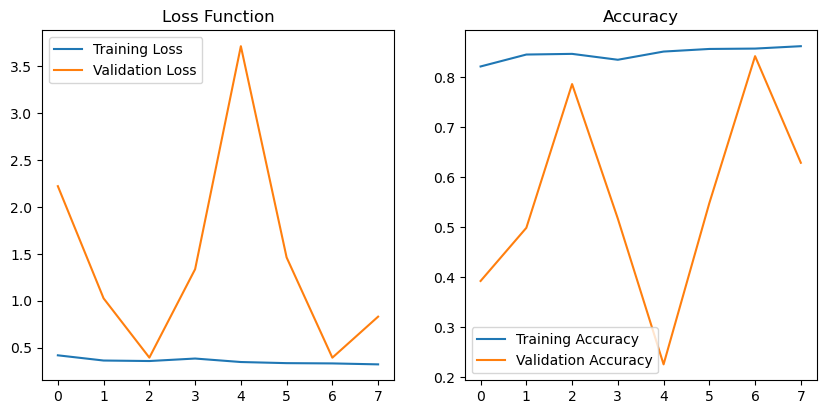

In [6]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [7]:
# model.save('/kaggle/working/resnet50_15000_75x75.h5')

In [8]:
# model = load_model('/kaggle/working/xception_15000_75x75.h5')

In [9]:
# Load the test dataset
test_dataset_dir = '/kaggle/input/preprocessed-random-5000-75px/preprocessed_random_5000_75px'
print("Loading the test dataset...")

# Load the preprocessed dataset
image_paths_0 = [os.path.join(dataset_dir, "0", img) for img in os.listdir(os.path.join(dataset_dir, "0"))]
image_paths_1 = [os.path.join(dataset_dir, "1", img) for img in os.listdir(os.path.join(dataset_dir, "1"))]

# Combine the image paths and create corresponding labels (0 for "0" folder, 1 for "1" folder)
dataset_images = image_paths_0 + image_paths_1
dataset_labels = np.concatenate((np.zeros(len(image_paths_0)), np.ones(len(image_paths_1))))
print("Test Dataset loaded successfully.")

# Convert the dataset to numpy arrays
preprocessed_images = np.array(dataset_images)

# Preprocess the images in the dataset for evaluation
preprocessed_images = np.array([img_to_array(load_img(img, target_size=(75, 75))) for img in dataset_images])

# Perform predictions on the preprocessed dataset
print("Performing predictions on the preprocessed dataset...")
predicted_labels = model.predict(preprocessed_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
print("Predictions completed successfully.")

# Calculate evaluation metrics
accuracy = accuracy_score(dataset_labels, predicted_labels)
precision = precision_score(dataset_labels, predicted_labels, zero_division=1)
recall = recall_score(dataset_labels, predicted_labels)
f1 = f1_score(dataset_labels, predicted_labels)

# Calculate AUC-ROC
auc_roc = roc_auc_score(dataset_labels, predicted_labels)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(dataset_labels, predicted_labels)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(dataset_labels, predicted_labels)

# Calculate confusion matrix
confusion_mat = confusion_matrix(dataset_labels, predicted_labels)
tn, fp, fn, tp = confusion_mat.ravel()

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {auc_roc}")
print("ROC Curve:")
print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")
print("Precision-Recall Curve:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")


Loading the test dataset...
Test Dataset loaded successfully.
Performing predictions on the preprocessed dataset...
938/938 [==============================] - 20s 19ms/step
Predictions completed successfully.
Evaluation Metrics:
Accuracy: 0.746
AUC-ROC: 0.746
ROC Curve:
False Positive Rate: [0.     0.2222 1.    ]
True Positive Rate: [0.     0.7142 1.    ]
Precision-Recall Curve:
Precision: [0.5        0.76270824 1.        ]
Recall: [1.     0.7142 0.    ]
F1-score: 0.7376575087791779
Confusion Matrix:
True Negative: 11667
False Positive: 3333
False Negative: 4287
True Positive: 10713


Chosen Class: 0


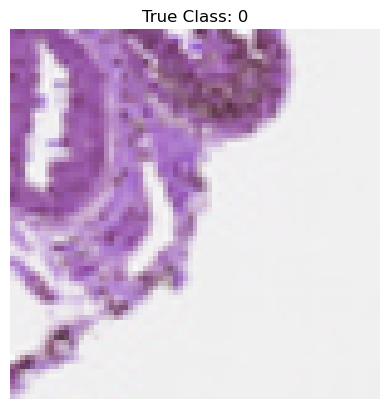

In [10]:
# select an image randomly and the image path 

# Function to load an image
def load_image(image_path):
    img = cv2.imread(image_path)
    return img

# Set the path to the main folder containing the class folders
main_folder = "/kaggle/input/preprocessed-random-100-75px/preprocessed_random_100_75px"

# Get the subfolders (class folders) within the main folder
class_folders = os.listdir(main_folder)

# Randomly choose a class folder
random_class_folder = random.choice(class_folders)

# Get the images within the chosen class folder
class_folder_path = os.path.join(main_folder, random_class_folder)
images = os.listdir(class_folder_path)

# Randomly choose an image from the class folder
random_image = random.choice(images)

# Construct the full path to the randomly chosen image
image_path = os.path.join(class_folder_path, random_image)

# Display the chosen class
class_label = random_class_folder
print("Chosen Class:", class_label)

# Load the image
image = load_image(image_path)

# Display the image and its true class
plt.imshow(image)
plt.title(f'True Class: {class_label}')
plt.axis('off')
plt.show()

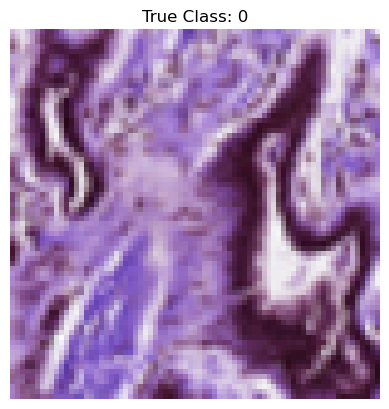

(75, 75, 3)


In [11]:
# select from class 0
zero_image_path = '/kaggle/input/sample-0/8864_idx5_x3001_y1051_class0.png'
zero_class_label = 0

zero_image = load_image(zero_image_path)

# Display the image and its true class
plt.imshow(zero_image)
plt.title(f'True Class: {zero_class_label}')
plt.axis('off')
plt.show()
print(zero_image.shape)

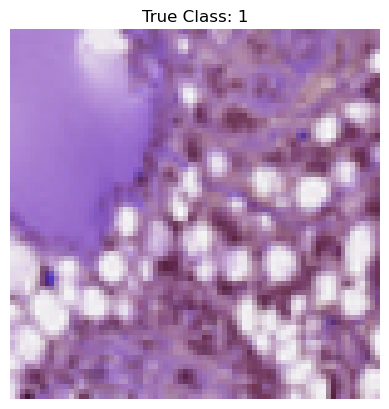

In [12]:
# select from class 1
one_image_path = '/kaggle/input/sample-1/8917_idx5_x451_y901_class1.png'
one_class_label = 1

one_image = load_image(one_image_path)

# Display the image and its true class
plt.imshow(one_image)
plt.title(f'True Class: {one_class_label}')
plt.axis('off')
plt.show()

**LIME**

In [13]:
def show_with_LIME(image):
    # Instantiate the LIME-Image explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate local explanations
    explanation = explainer.explain_instance(image, model.predict, top_labels=5, num_samples=1000)

    # Get the top predicted label
    top_label = np.argmax(model.predict(image[np.newaxis, :, :, :]))

    # Visualize the local explanations
    explanation_image, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=5, hide_rest=False)
    explanation_image = cv2.resize(explanation_image, (image.shape[1], image.shape[0]))  # Resize the explanation image to match the original image size
    
    # Display the image and its true class
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

#     # Load the explanation image
#     ex_image = load_image(explanation_image_path)

    # Display the image and its true class
    plt.imshow(explanation_image)
    plt.title("Explanation Image")
    plt.axis('off')
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 559ms/step


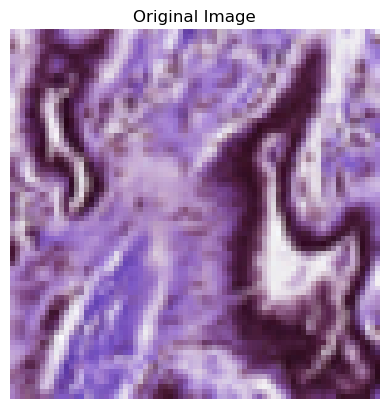

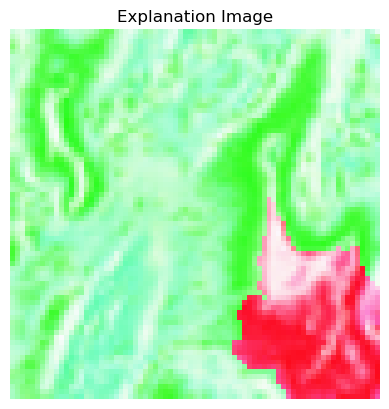

In [14]:
show_with_LIME(zero_image)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


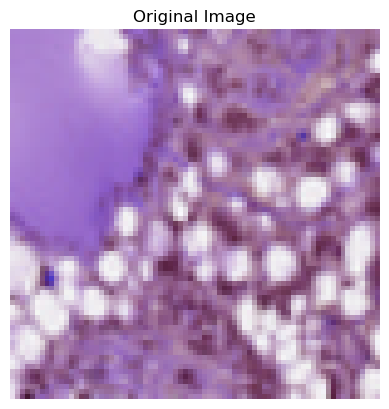

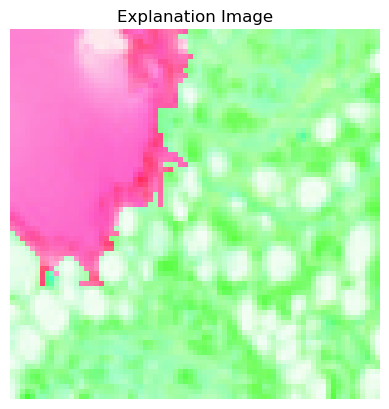

In [15]:
show_with_LIME(one_image)

**GRAD-CAM**

In [16]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 75x75
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (75, 75, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 75, 75, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [17]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [18]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    cam_image = Image.open(cam_path)
    cam_image_resized_to_display = cam_image.resize((300, 300))
    print("Image with GRAD-CAM explanation")
    display(cam_image_resized_to_display)
    # display(Image(cam_path))

In [19]:
def generate_heatmap(image_path):
    image = Image.open(image_path)
    resized_image_to_display = image.resize((300, 300))
    display(resized_image_to_display)

    # Get image details
    image_details = {
        "Path": image_path,
        "Filename": random_image,
        "Width": image.width,
        "Height": image.height,
        "Format": image.format,
        "Size": image.size,
        "all": image
    }
    # display class detils 
    print("Class Label:" , class_label)

    # Display image details
    print("Image Details:")
    for key, value in image_details.items():
        print(key + ":", value)
    
    preprocess_input = keras.applications.resnet50.preprocess_input
    decode_predictions = keras.applications.resnet50.decode_predictions
    img_size = image.size

    # Make model
#     model = load_model('/kaggle/working/vgg16_100_75x75.h5')

    # Prepare image
    img_array = preprocess_input(get_img_array(image_path, size=img_size))

    last_conv_layer_name = "conv5_block3_out"

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    return heatmap

CLASS 0 EXPLANATION

Explantion for the zero class image


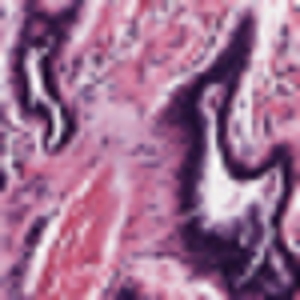

Class Label: 0
Image Details:
Path: /kaggle/input/sample-0/8864_idx5_x3001_y1051_class0.png
Filename: 10305_idx5_x1951_y1501_class0.png
Width: 75
Height: 75
Format: PNG
Size: (75, 75)
all: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=75x75 at 0x7D2362A92530>
1/1 [==============================] - 0s 28ms/step


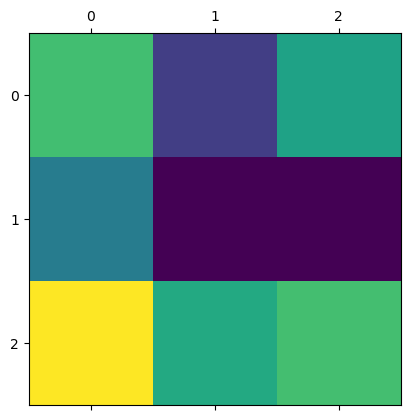

Image with GRAD-CAM explanation


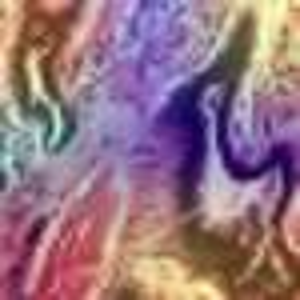

In [20]:
print("Explantion for the zero class image")
heatmap = generate_heatmap(zero_image_path)
save_and_display_gradcam(zero_image_path, heatmap)

CLASS 1 EXPLANATION

Explantion for the one class image


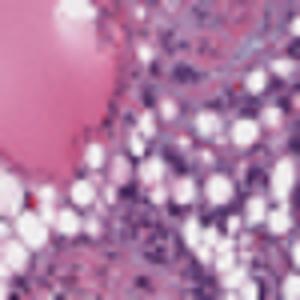

Class Label: 0
Image Details:
Path: /kaggle/input/sample-1/8917_idx5_x451_y901_class1.png
Filename: 10305_idx5_x1951_y1501_class0.png
Width: 75
Height: 75
Format: PNG
Size: (75, 75)
all: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=75x75 at 0x7D22D8014D60>
1/1 [==============================] - 0s 27ms/step


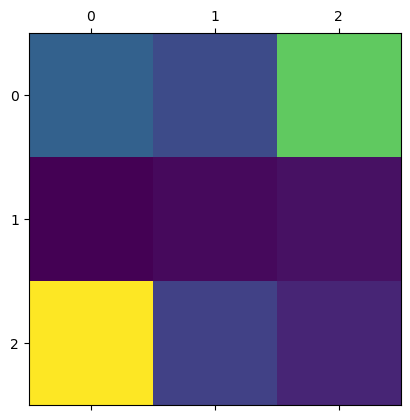

Image with GRAD-CAM explanation


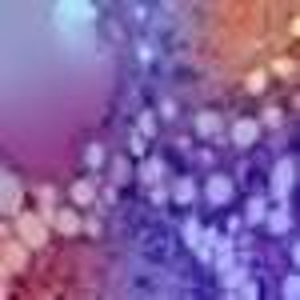

In [21]:
print("Explantion for the one class image")
heatmap = generate_heatmap(one_image_path)
save_and_display_gradcam(one_image_path, heatmap)